Read in data and do primitive feature engineering as talked in 02

In [1]:
from pandas import read_csv
import re


# perform for every race
perform = read_csv('./horse/data/performance.txt', sep=':', encoding='utf-8')


# Pla.
# Rule 2
perform['Pla.'] = perform['Pla.'].apply(lambda x: x.replace(' 平頭馬', ''))
# Rule 1
perform = perform[
            perform['Pla.'].str.contains('|'.join([str(i) for i in list(range(10))]))
          ].reset_index(drop=True) \

# Course
perform['Course Type'] = perform['Course Type'].apply(lambda x: x.split(' - ')[0])

# Distance
perform['Distance'] = perform['Distance'].apply(lambda x: (x.split(' - ')[1])[:-1])

# Finish Time
perform['Finish Time'] = perform['Finish Time(min)'].astype(int)*60 \
                              + perform['Finish Time(sec)'].astype(float)

# champion
perform['is_champ'] = perform['Pla.'].apply(lambda x: 1 if x==1 else 0)

# money
perform['Race Money'] = perform['Race Money'].apply(lambda x: x[3:].replace(',', ''))

# Transform Data Type
perform['Pla.'] = perform['Pla.'].astype(int)
perform['Distance'] = perform['Distance'].astype(int)
perform['Race Money'] = perform['Race Money'].astype(int)


perform['race_key'] = perform['Race Date'].astype(str)+ '_' + perform['Race No.'].astype(str)

perform = perform[['race_key', 'Race Date'
                   , 'Dr.', 'Distance', 'Field Going', 'Course Type', 'Race Money'
                   , 'Act. Wt.', 'Declare. Horse Wt.', 'Win Odds', 'Horse', 'Jockey', 'Trainer'
                   , 'is_champ', 'Pla.', 'Finish Time']]

cols = ['_'.join(item.replace('.', '').lower().split(' ')) for item in perform.columns.tolist()]

perform.columns = cols
perform = perform.sort_values(by=['race_key', 'pla'], ascending=True)

perform.head()

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time
53437,2015/04/22_1,2015/04/22,2,1000,好地至快地,草地,575000,120,1186,7.3,有情風(N139),薛寶力,吳定強,0,1,57.37
53438,2015/04/22_1,2015/04/22,3,1000,好地至快地,草地,575000,132,1022,6.1,樂趣(S150),韋達,霍利時,0,2,57.53
53439,2015/04/22_1,2015/04/22,5,1000,好地至快地,草地,575000,121,1085,48.0,穩佔先機(N359),連達文,苗禮德,0,3,57.78
53440,2015/04/22_1,2015/04/22,7,1000,好地至快地,草地,575000,127,1211,7.8,上浦勇將(P285),田泰安,徐雨石,0,4,57.82
53441,2015/04/22_1,2015/04/22,1,1000,好地至快地,草地,575000,124,1088,14.0,大地王者(L251),黎海榮,李易達,0,5,57.89


In [2]:
from horse.process import train_test_split

train, test = train_test_split(perform, 'race_date', 0.1)

In [114]:
""" Fields

参赛信息：
    1. 历史几场比赛
    2. 是否新马/骑手/马师
    3. 上次比赛距今多久(d) 
    4. 赛龄(d)

表现信息：
    1. 历史最高名次
    2. 是否冠军
    3. 是否前三
    4. 冠军率
    5. 前三率

"""

def perform_extract(data, entity):
    import numpy as np

    # showup counts: 历史几场比赛
    showups = train.groupby([entity, 'race_date']).size() \
                .groupby(level=0).cumsum()\
                .groupby(level=0).shift().reset_index() \
                .rename(columns={0:'showups'})
    showups = showups.fillna(0)

    # 是否新马
    showups['is_new'] = showups['showups'].apply(lambda x: 1 if x==0 else 0)
    # 上场比赛距今天数
    showups['last_comp_days'] = (showups['race_date'].astype(np.datetime64)  # current racing date
                                -showups.groupby([entity])['race_date'].shift().astype(np.datetime64) # last racing date
                                )/np.timedelta64(1, 'D') # in date form
    # 历史最高名次
    hist_best_perform = train.groupby([entity, 'race_date'])['pla'].cummin() \
                        .groupby(level=0).shift().reset_index() \
                        .rename(columns={'pla':'hist_best_perform'})
    # 最早比赛时间
    earliest_race = showups.groupby(entity)['race_date'] \
                        .min().reset_index() \
                        .rename(columns={'race_date':'earliest_race_date'})
    showups = showups.merge(earliest_race, on=entity, how='left')
    # 赛龄(日)
    showups['life_time_d'] = (showups['race_date'].astype(np.datetime64)  # current racing date
                                -showups['earliest_race_date'].astype(np.datetime64) # last racing date
                                )/np.timedelta64(1, 'D') # in date form

    # hist_perform = train.groupby([entity, 'race_date'])['pla'].min().reset_index()
    hist_perform = train[[entity, 'race_date', 'pla']]
    # hist_perform['hist_best_perform'] = hist_perform.groupby([entity])['pla'].apply(lambda x: x.cummin().shift())

    # 当场是否冠军
    hist_perform['is_champ'] = (hist_perform['pla']==1).astype(int)
    # 历史冠军数
    hist_champs = hist_perform.groupby([entity, 'race_date', 'pla'])['is_champ'].sum() \
                                .groupby(level=0).cumsum() \
                                .groupby(level=0).shift().reset_index() \
                                .rename(columns={'is_champ':'hist_champs'})
    # hist places count (exclude current run)
    hist_perform['is_place'] = (hist_perform['pla']<=3).astype(int)
    hist_places = hist_perform.groupby([entity, 'race_date', 'pla'])['is_place'].sum() \
                                .groupby(level=0).cumsum() \
                                .groupby(level=0).shift().reset_index() \
                                .rename(columns={'is_place':'hist_places'})

    # remove useless columns
    # del hist_perform['pla']
    del hist_champs['pla'], hist_places['pla']

    showups = showups.merge(hist_places, on=[entity, 'race_date'], how='left') \
                    .merge(hist_champs, on=[entity, 'race_date'], how='left') \
                    .merge(hist_perform, on=[entity, 'race_date'], how='left') \

    showups['hist_champ_rate'] = (showups['hist_champs']/showups['showups']).fillna(0)
    showups['hist_place_rate'] = (showups['hist_places']/showups['showups']).fillna(0)


    showups['hist_places'] = showups['hist_places'].fillna(0)
    showups['hist_champs'] = showups['hist_champs'].fillna(0)

    # del showups['is_champ'], showups['is_place']
    del showups['earliest_race_date']
    del showups['pla']

    showups.columns = [col if col in [entity, 'race_date'] else f'{entity}_{col}'
                       for col in showups.columns.tolist()]

    return showups


horse_showups = perform_extract(train, 'horse')
# jockey_showups = perform_extract(train, 'jockey')
# trainer_showups = perform_extract(train, 'trainer')

C:\Users\Shenghui\AppData\Local\Temp\ipykernel_18248\2720560103.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_perform['is_champ'] = (hist_perform['pla']==1).astype(int)
C:\Users\Shenghui\AppData\Local\Temp\ipykernel_18248\2720560103.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_perform['is_place'] = (hist_perform['pla']<=3).astype(int)


In [112]:
horse_showups.shape, horse_showups.drop_duplicates().shape

((48715, 12), (48715, 12))

In [115]:
horse_showups

,horse,race_date,horse_showups,horse_is_new,horse_last_comp_days,horse_life_time_d,horse_hist_places,horse_hist_champs,horse_is_champ,horse_is_place,horse_hist_champ_rate,horse_hist_place_rate
0,一代莊主(C419),2019/09/08,0.0,1,NaN,0.0,0.0,0.0,0,0,0.000000,0.000000
1,一代莊主(C419),2019/12/01,1.0,0,84.0,84.0,0.0,0.0,0,0,0.000000,0.000000
2,一代莊主(C419),2019/12/29,2.0,0,28.0,112.0,0.0,0.0,0,0,0.000000,0.000000
3,一代莊主(C419),2020/06/14,3.0,0,168.0,280.0,0.0,0.0,0,0,0.000000,0.000000
4,一代莊主(C419),2020/07/12,4.0,0,28.0,308.0,0.0,0.0,1,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
48710,龍鼓飛揚(C120),2021/11/07,12.0,0,21.0,966.0,4.0,2.0,0,0,0.166667,0.333333
48711,龍鼓飛揚(C120),2021/11/21,13.0,0,14.0,980.0,4.0,2.0,0,1,0.153846,0.307692
48712,龜兔競跑(L428),2015/04/26,0.0,1,NaN,0.0,0.0,0.0,0,0,0.000000,0.000000
48713,龜兔競跑(L428),2015/05/24,1.0,0,28.0,28.0,0.0,0.0,0,0,0.000000,0.000000


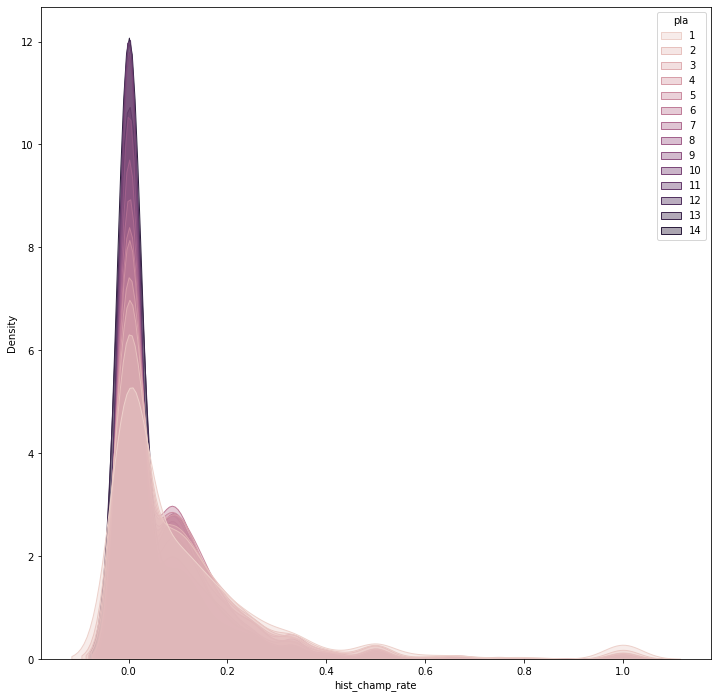

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"]=12, 12

# # 对马而言，赛龄可能是一个很重要的特征
sns.kdeplot(data=showups, x="hist_champ_rate", hue="pla", fill=True, common_norm=False, alpha=0.4)

plt.show()

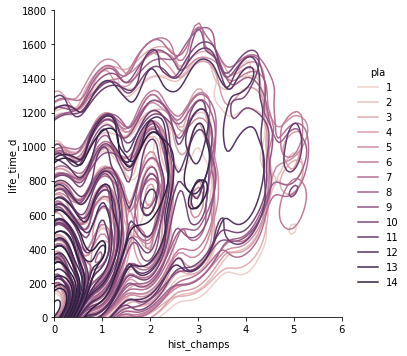

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"]=18, 18

# # 对马而言，赛龄可能是一个很重要的特征
# sns.kdeplot(data=showups, x="hist_champs", hue="pla", fill=True, common_norm=False, alpha=0.4)

# sns.scatterplot(data=showups, x="hist_champs", y="life_time_d", hue="pla")
p = sns.displot(showups, x="hist_champs", y="life_time_d", kind="kde", hue="pla")

p.axes[0][0].set_ylim(0,1800)
p.axes[0][0].set_xlim(0,6)

plt.show()

In [79]:
# p.axes.set_ylim(0, 1800)
# p.axes.set_xlim(0, 6)


<AxesSubplot:xlabel='hist_champs', ylabel='life_time_d'>

In [76]:
p.axes[0]

array([<AxesSubplot:xlabel='hist_champs', ylabel='life_time_d'>],
      dtype=object)